# CNNs with GloVe

# 1. Setup

# 1.1. Enabling the GPU on Colab

In [ ]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()

if len(device_name) > 0:
    print('Found GPU at: {}'.format(device_name))
    
else:
    device_name = '/device:CPU:0'
    print('No GPU, using {}.'.format(device_name))

Found GPU at: /device:GPU:0


# 1.2. Libraries

In [ ]:
!pip install keras-tuner -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 KB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.6 MB/s eta 0:00:00


In [ ]:
from keras.layers import Conv1D, GlobalMaxPooling1D, Dropout
from keras.layers import Embedding, Dense, Activation
from keras.utils.data_utils import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import sequence 
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt

from keras.callbacks import TensorBoard, EarlyStopping
from keras_tuner.tuners import Hyperband
from keras.utils import plot_model
import keras_tuner as kt

from nltk.tokenize import TreebankWordTokenizer
from gensim.models.keyedvectors import KeyedVectors
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from google.colab import drive

import numpy as np
import pandas as pd

# 2. Loading the Grey's Anatomy Dataset

In [ ]:
# Accessing Drive files
drive.mount('/content/drive')

# Paths to the corpus
CORPUS_PATH = '/content/drive/MyDrive/DAR/greys_anatomy_data_train_val_test.xlsx'

# Path to the embeddings
GLOVE_VECTORS = '/content/drive/MyDrive/embeddings/glove.6B.100d.txt'

# Opening aligned .xlsx file 
data = pd.read_excel(CORPUS_PATH, index_col=0)

Mounted at /content/drive


# 3. Tokenizing and padding

In [ ]:
# Training set features
max_length = 35
tokenizer_obj = Tokenizer(oov_token='<OOV>')
tokenizer_obj.fit_on_texts(data[data.data_type=='train'].subtitle_text.values)
sequences_train = tokenizer_obj.texts_to_sequences(data[data.data_type=='train'].subtitle_text.values)
padding_train = pad_sequences(sequences_train, maxlen=max_length, padding='post', truncating='post') # Padding to the longest sentence
word_index = tokenizer_obj.word_index

# Validation set features
sequences_val = tokenizer_obj.texts_to_sequences(data[data.data_type=='val'].subtitle_text.values)
padding_val = pad_sequences(sequences_val, maxlen=max_length, padding='post', truncating='post')

# Targets
expected_train = data[data.data_type=='train'][['pp', 'sp', 'mc']].values
expected_val = data[data.data_type=='val'][['pp', 'sp', 'mc']].values

# Renaming the variables
X_train = padding_train
y_train = expected_train
X_val = padding_val
y_val = expected_val

In [ ]:
# Network parameters

maxlen = 35      
batch_size = 32      
embedding_dims = 100  # GloVe dimensions

In [ ]:
# X shape is (number of samples, sequence length)
# Y shape is (number of samples, classes)

print('Shape of X_train:', X_train.shape) # 55567 samples, 35 maxlen
print('Shape of y_train:', y_train.shape) # 55567 samples, 3 classes
print('Shape of X_val:', X_val.shape)   # 11907 samples, 35 maxlen
print('Shape of y_val:', y_val.shape) # 11907 samples, 3 classes

Shape of X_train: (55567, 35)
Shape of y_train: (55567, 3)
Shape of X_val: (11907, 35)
Shape of y_val: (11907, 3)


# 4. Creating the embedding matrix

In [ ]:
# Loading the GloVe embeddings 

embedding_index = {}
embedding_dim = 100

f = open(GLOVE_VECTORS, encoding="utf8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embedding_index))

Found 400000 word vectors.


In [ ]:
# Creating the embedding matrix

embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
# Defining the embedding layer for the network

embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

# 5. Creating the baseline CNN

In [ ]:
# Creating a convolutional neural network for multioutput regression

model_glove = Sequential()
model_glove.add(embedding_layer)
model_glove.add(Conv1D(filters=250, kernel_size=3, padding='valid', activation='relu', strides=1, input_shape=(maxlen, embedding_dims)))
model_glove.add(GlobalMaxPooling1D())
model_glove.add(Dense(250))
model_glove.add(Dropout(0.2))
model_glove.add(Activation('relu'))
model_glove.add(Dense(3, activation='sigmoid'))

In [ ]:
# Compiling the CNN

model_glove.compile(loss='mse', optimizer='adam', metrics=['mae'])

# 6. Training the baseline CNN

In [ ]:
# Training the CNN

checkpoint = ModelCheckpoint('model-{epoch:03d}-{val_loss:03f}.h5', verbose=1, monitor='val_loss', save_best_only=True, mode='auto')
history_glove = model_glove.fit(X_train, y_train, epochs=8, batch_size=32, validation_data=(X_val, y_val), callbacks=[checkpoint], verbose=1)

Epoch 1/8
1728/1737 [============================>.] - ETA: 0s - loss: 0.1521 - mae: 0.3362
Epoch 1: val_loss improved from inf to 0.15031, saving model to model-001-0.150308.h5
1737/1737 [==============================] - 7s 4ms/step - loss: 0.1521 - mae: 0.3362 - val_loss: 0.1503 - val_mae: 0.3339
Epoch 2/8
1730/1737 [============================>.] - ETA: 0s - loss: 0.1478 - mae: 0.3294
Epoch 2: val_loss improved from 0.15031 to 0.14928, saving model to model-002-0.149281.h5
1737/1737 [==============================] - 6s 4ms/step - loss: 0.1478 - mae: 0.3294 - val_loss: 0.1493 - val_mae: 0.3324
Epoch 3/8
1728/1737 [============================>.] - ETA: 0s - loss: 0.1438 - mae: 0.3225
Epoch 3: val_loss did not improve from 0.14928
1737/1737 [==============================] - 7s 4ms/step - loss: 0.1438 - mae: 0.3226 - val_loss: 0.1505 - val_mae: 0.3336
Epoch 4/8
1723/1737 [============================>.] - ETA: 0s - loss: 0.1391 - mae: 0.3143
Epoch 4: val_loss did not improve from 0

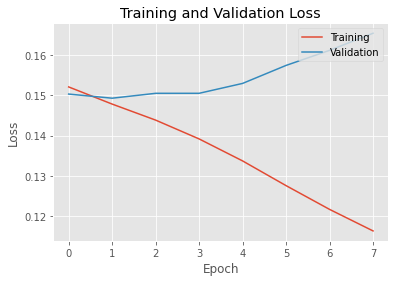

In [ ]:
# Summarize history for loss

plt.plot(history_glove.history['loss'])
plt.plot(history_glove.history['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# 7. Testing the baseline CNN on the hold-out partition

In [ ]:
# Test set features

sequences_test = tokenizer_obj.texts_to_sequences(data[data.data_type=='test'].subtitle_text.values)
padding_test = pad_sequences(sequences_test, maxlen=max_length, padding='post', truncating='post')
X_test = padding_test

In [ ]:
# Test targets

expected_test = data[data.data_type=='test'][['pp', 'sp', 'mc']].values
y_test = expected_test

In [ ]:
# Predicting on the test set

model_pred = model_glove.predict(X_test)

373/373 [==============================] - 1s 2ms/step


In [ ]:
# Evaluating with MAE

print('MAE (ALL) ', mean_absolute_error(y_test, model_pred), ' \n')
print('MAE (PP): ', list(mean_absolute_error(y_test, model_pred, multioutput='raw_values'))[0])
print('MAE (SP): ', list(mean_absolute_error(y_test, model_pred, multioutput='raw_values'))[1])
print('MAE (MC): ', list(mean_absolute_error(y_test, model_pred, multioutput='raw_values'))[2])

MAE (ALL)  0.32367263830327847  

MAE (PP):  0.2404629343676838
MAE (SP):  0.3801482403456686
MAE (MC):  0.35040674019648305


In [ ]:
# Evaluating with RMSE

print('RMSE (ALL) ', mean_squared_error(y_test, model_pred), ' \n')
print('RMSE (PP): ', list(mean_squared_error(y_test, model_pred, squared=False, multioutput='raw_values'))[0])
print('RMSE (SP): ', list(mean_squared_error(y_test, model_pred, squared=False, multioutput='raw_values'))[1])
print('RMSE (MC): ', list(mean_squared_error(y_test, model_pred, squared=False, multioutput='raw_values'))[2])

RMSE (ALL)  0.16550187316698284  

RMSE (PP):  0.33837186190593976
RMSE (SP):  0.4445073507139265
RMSE (MC):  0.4294453605903113


In [ ]:
from sklearn.metrics import r2_score

# Evaluating with R2 

print('R2 (ALL) ', r2_score(y_test, model_pred), ' \n')
print('R2 (PP): ', list(r2_score(y_test, model_pred, multioutput='raw_values'))[0])
print('R2 (SP): ', list(r2_score(y_test, model_pred, multioutput='raw_values'))[1])
print('R2 (MC): ', list(r2_score(y_test, model_pred, multioutput='raw_values'))[2])

R2 (ALL)  -0.05880862052655448  

R2 (PP):  -0.05866078461523516
R2 (SP):  -0.05756428225127275
R2 (MC):  -0.06020079471315554


# 8. CNN with Hyperparameter Tuning 

In [ ]:
# Initializing the container for the hyperparameters

hp = kt.HyperParameters()

In [ ]:
# Defining the hyperparameters to explore, based on the CNN from before

def build_hypermodel(hp):

  hp_loss = hp.Choice('loss_function', values=['mse', 'mae'])                          # Loss functions: MSE and MAE
  hp_kernel = hp.Choice('kernel_size', values=[1, 2, 3, 4, 5])                         # Kernel sizes: from 1 to 3
  hp_filters = hp.Int('conv_filters', min_value=50, max_value=250, step=25)            # Number of filters: from 50 to 250, with a step of 25 (e.g. it can be 75, 100 etc.)
  hp_learning_rate = hp.Choice('adam_learning_rate', values = [0.002, 0.001, 0.0001])  # Learning rates for the optimizer: 0.002, 0.001, 0.0001
  hp_dense_units = hp.Int('dense_units', min_value=32, max_value=512, step=32)         # Number of units in the Dense layer: from 32 to 512, with a step of 32
  hp_dropout = hp.Choice('dropout_value', values=[0.05, 0.1, 0.2, 0.3])                # Dropout value: 0.05, 0.1, 0.2, 0.3
  hp_layers = hp.Int('num_intermediate_layers', 1, 3)                                  # Intermediate layers: from 1 to 3 sections of Dense layers with Dropout

  model_hp = Sequential()
  model_hp.add(embedding_layer)
  model_hp.add(Conv1D(filters=hp_filters, kernel_size=hp_kernel, padding='same', activation='relu', strides=1, input_shape=(maxlen, embedding_dims)))
  model_hp.add(GlobalMaxPooling1D())

  for i in range(hp_layers):  
    model_hp.add(Dense(units=hp_dense_units, activation='relu'))
    model_hp.add(Dropout(hp_dropout))

  model_hp.add(Activation('relu'))
  model_hp.add(Dense(3))

  model_hp.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss=hp_loss, metrics=['mse'])

  return model_hp

In [ ]:
# Hyperband is one of the optimization algorithms provided by Keras Tuner

tuner = Hyperband(build_hypermodel, 
                  objective='mse',        # Objective to minimize
                  executions_per_trial=1, # Number of models that should be built and fit for each trial 
                  hyperband_iterations=1, # The number of times the Hyperband algorithm is iterated over
                  max_epochs=4, 
                  project_name='cnn_keras_tuner')

In [ ]:
tuner.search(X_train, y_train, batch_size=32, # Batch size -> another parameter that can be explored
             epochs=20,
             validation_data=(X_val, y_val),
             callbacks=[EarlyStopping('mse', patience=5)], # Patience -> number of epochs with no improvement after which training will be stopped; I set it a bit higher to explore more configurations
             verbose=2)

Trial 10 Complete [00h 00m 27s]
mse: 0.1449563056230545

Best mse So Far: 0.1449563056230545
Total elapsed time: 00h 04m 05s


In [ ]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(1)[0]

# Get the best model
best_model = tuner.get_best_models(1)[0]

# Show model summary
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 35, 100)           1380200   
                                                                 
 conv1d (Conv1D)             (None, 35, 50)            10050     
                                                                 
 global_max_pooling1d (Globa  (None, 50)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 352)               17952     
                                                                 
 dropout (Dropout)           (None, 352)               0         
                                                                 
 dense_1 (Dense)             (None, 352)               124256    
                                                        

In [ ]:
# Show the optimal hyperparameters 

best_hps.values

{'kernel_size': 2,
 'conv_filters': 50,
 'adam_learning_rate': 0.001,
 'dense_units': 352,
 'dropout_value': 0.1,
 'num_intermediate_layers': 2,
 'tuner/epochs': 4,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [ ]:
# Build and train the model with the optimal hyperparameters

checkpoint = ModelCheckpoint('model2-{epoch:03d}-{val_loss:03f}.h5', verbose=1, monitor='val_loss', save_best_only=True, mode='auto')

model_hp = tuner.hypermodel.build(best_hps)
model_hp.fit(X_train, y_train, 
           validation_data=(X_val, y_val), 
           epochs=8,
           batch_size=32,
           callbacks=[checkpoint], verbose=1) 

Epoch 1/8
1733/1737 [============================>.] - ETA: 0s - loss: 0.1541 - mse: 0.1541
Epoch 1: val_loss improved from inf to 0.15155, saving model to model2-001-0.151547.h5
1737/1737 [==============================] - 8s 4ms/step - loss: 0.1541 - mse: 0.1541 - val_loss: 0.1515 - val_mse: 0.1515
Epoch 2/8
1732/1737 [============================>.] - ETA: 0s - loss: 0.1494 - mse: 0.1494
Epoch 2: val_loss improved from 0.15155 to 0.15149, saving model to model2-002-0.151487.h5
1737/1737 [==============================] - 8s 4ms/step - loss: 0.1493 - mse: 0.1493 - val_loss: 0.1515 - val_mse: 0.1515
Epoch 3/8
1728/1737 [============================>.] - ETA: 0s - loss: 0.1473 - mse: 0.1473
Epoch 3: val_loss improved from 0.15149 to 0.15092, saving model to model2-003-0.150918.h5
1737/1737 [==============================] - 7s 4ms/step - loss: 0.1473 - mse: 0.1473 - val_loss: 0.1509 - val_mse: 0.1509
Epoch 4/8
1735/1737 [============================>.] - ETA: 0s - loss: 0.1455 - mse: 0

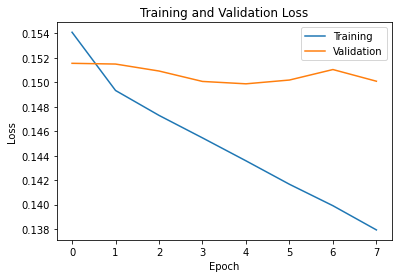

In [ ]:
# Summarize history for loss

plt.plot(model_hp.history.history['loss'])
plt.plot(model_hp.history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# 9. Testing the optimized CNN on the hold-out partition

In [ ]:
# Predicting with the optimized CNN

model_pred_2 = model_hp.predict(X_test)

373/373 [==============================] - 1s 2ms/step


In [ ]:
# Evaluating with MAE

print('MAE (ALL) ', mean_absolute_error(y_test, model_pred_2), ' \n')
print('MAE (PP): ', list(mean_absolute_error(y_test, model_pred_2, multioutput='raw_values'))[0])
print('MAE (SP): ', list(mean_absolute_error(y_test, model_pred_2, multioutput='raw_values'))[1])
print('MAE (MC): ', list(mean_absolute_error(y_test, model_pred_2, multioutput='raw_values'))[2])

MAE (ALL)  0.3343011733109483  

MAE (PP):  0.2614793595326635
MAE (SP):  0.376425691485377
MAE (MC):  0.3649984689148044


In [ ]:
# Evaluating with RMSE

print('RMSE (ALL) ', mean_squared_error(y_test, model_pred_2), ' \n')
print('RMSE (PP): ', list(mean_squared_error(y_test, model_pred_2, squared=False, multioutput='raw_values'))[0])
print('RMSE (SP): ', list(mean_squared_error(y_test, model_pred_2, squared=False, multioutput='raw_values'))[1])
print('RMSE (MC): ', list(mean_squared_error(y_test, model_pred_2, squared=False, multioutput='raw_values'))[2])

RMSE (ALL)  0.1501921119661304  

RMSE (PP):  0.32502533579675685
RMSE (SP):  0.4198586956009183
RMSE (MC):  0.41067449728086597


In [ ]:
# Evaluating with R2

from sklearn.metrics import r2_score

print('R2 (ALL) ', r2_score(y_test, model_pred_2), ' \n')
print('R2 (PP): ', list(r2_score(y_test, model_pred_2, multioutput='raw_values'))[0])
print('R2 (SP): ', list(r2_score(y_test, model_pred_2, multioutput='raw_values'))[1])
print('R2 (MC): ', list(r2_score(y_test, model_pred_2, multioutput='raw_values'))[2])

R2 (ALL)  0.03671102686566696  

R2 (PP):  0.023206468139489567
R2 (SP):  0.056471148463256404
R2 (MC):  0.030455463994254917
